In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# MNIST

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

사이킷런에서 읽어들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고 있다. 
- 데이터셋을 설명하는 DESR 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가지고 있는 data키
- 레이블 배열을 담고 있는 target키 

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


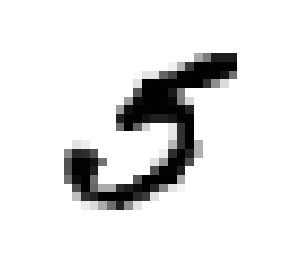

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [6]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [7]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


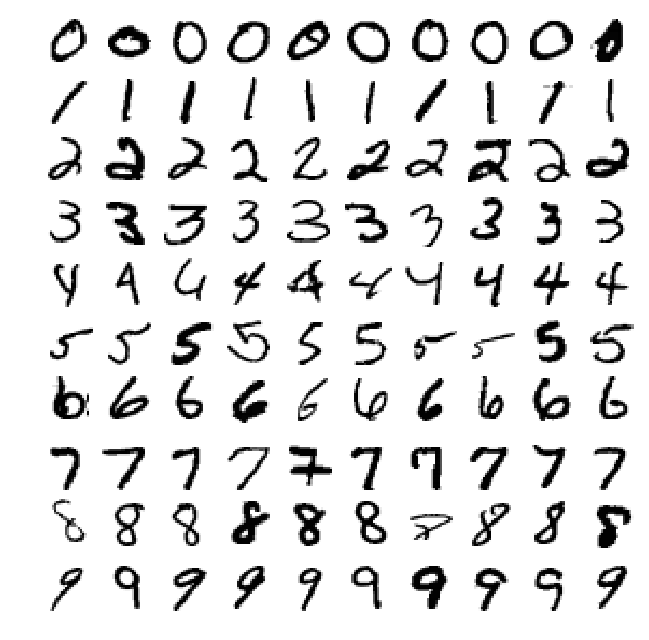

In [8]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 이진 분류기

5만 식별하는 이진 분류기 

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

In [14]:
#폴드가 3개인 k-겹 교차검증 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

In [16]:
from  sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

# 오차행렬

분류기의 성능을 평가하는 방법 A클래스 샘플이 B클래스로 분류된 횟수를 세는 것이다. 예를 들ㅇ 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 된다. 

confusion_matrix(y_train, y_pred)
- 실제타겟값(y_train)과 이와 비교할 예측값(y_pred)가 필요하다
- cross_val_predict : 각각의 테스트 폴트에서 얻은 예측을 반환한다.이는 훈련셋의 모든 샘플에 대해서 깨끗한 예측을 한다(깨끗:모델이 훈련하는 동안 보지 못한 데이터에 대해 예측한 것)
- 행(실제값), 열(예측값)으로 나타난다.

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

In [20]:
#100% 정확도의 값일 때 
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

정밀도(precision)
- 양성 예측 정확도(TP/TP+FP)

재현율 또는 민감도 또는 진짜 양성 비율(TPR)
- 양성 실제 정확도(TP/TP+FN)

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7687135020350381

In [22]:
recall_score(y_train_5, y_train_pred)

0.801328168234643

F1_score
- 정밀도와 재현율의 조화평균(harmonic mean)

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

- 재현율 : 얼마나 많이 좋은 결과가 나타나는가?
- 정확도 : 얼마나 좋은것과 나쁜것의 구별을 잘하는가?

이 두가지는 하나가 좋아지면 나머지 하나의 값은 떨어지게 된다. 이 두가지를 모두 좋게 가지기는 어렵다. 그렇다면 상황에 따라 중요한 것을 올리는 것이 중요하다. 

## 정밀도/재현율 트레이드오프

SGDClassifier가 분류를 어떻게 하는지 살볼것이다. 이 분류기는 결정함수를 사용하여 각 샘플의 점수를 계산한다. 
- 결정함수 > 임계각 = True
- 결정함수 < 임계각 = False

In [24]:
#예측에 사용한 점수 확인하기
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [27]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [28]:
#cross_val_predict()를 사용해 훈련셋에 있는 모든 샘플의 점수를 구함
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                            method ='decision_function')

In [29]:
y_scores.shape

(60000,)

In [31]:
#precision_recall_curve() 
#모든 임곗값에 대한 정밀도와 재현율을 계산한다.
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


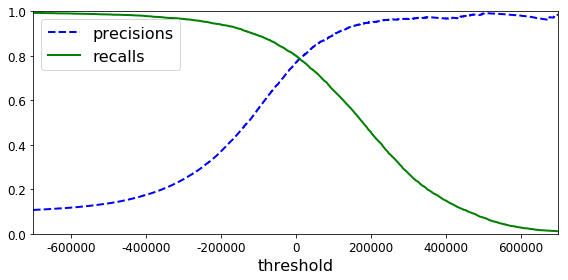

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precisions", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recalls", linewidth=2)
    plt.xlabel("threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [35]:
#이 코드를 통해서 SGDClasscifier가 임계각 0을 가진다는 것을 확인가능
(y_train_pred == (y_scores > 0)).all()

True

정밀도 90에 해당하는 결과를 내기 위해서 그래프를 보았을 때 임계각이 약 70,000 임을 알 수 있다. 그에 대한 예측을 만들기 위해서 다음의 방법으로 에측을 만들 수 있다. 

In [37]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.8659205116491548

In [39]:
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


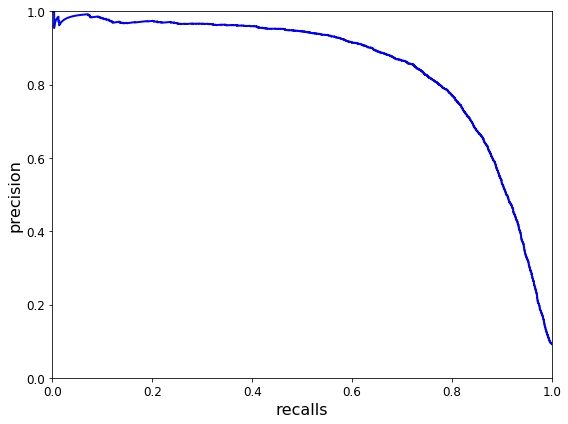

In [41]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("recalls", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

## ROC곡선

이진 분류에서 널리 사용되는 도구로 정밀도/재현율 곡선과 비슷하지만 이는 거짓 양성 비율(false positive rate.FPR)에 대한 진짜 양성 비율(true positive rate.TPR)의 곡선이다. FPR은  양성으로 잘못 분류된 음성 샘플의 비율이고 TPR은 재현율의 다른 이름이다. 즉 ROC곡선은 민감도(재현율)에 대한 1-특이도 그래프이다.

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


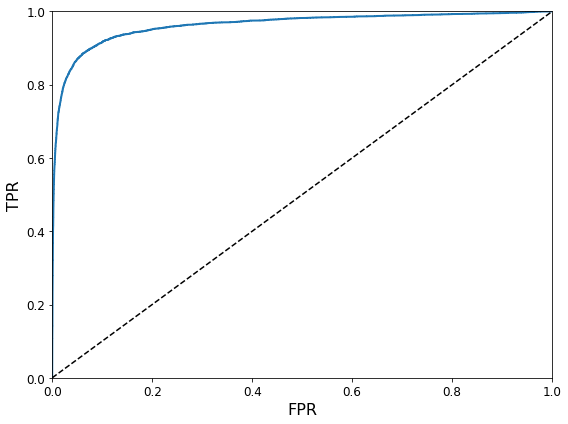

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

재현율이 높을 수록 분류기가 만드는 거짓 양성이 늘어납니다. 점선은 완전한 랜덤분류기의 ROC곡선을 나타냅니다. 

In [45]:
#곡선 아래면적(AUC)을 측정하면 분류기를 비교 할 수 있다. 
#분류기는 ROC의 AUC 1, 완전랜덤 분류기는 0.5이다.
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967155

In [46]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [47]:
y_scores_forest = y_probas_forest[:, 1] # 점수는 양상 클래스의 확률입니다
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


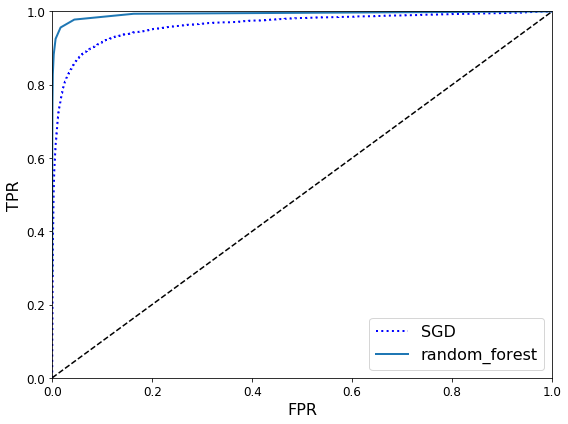

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "random_forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [51]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [52]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

# 더미 (즉, 랜덤) 분류기

In [76]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


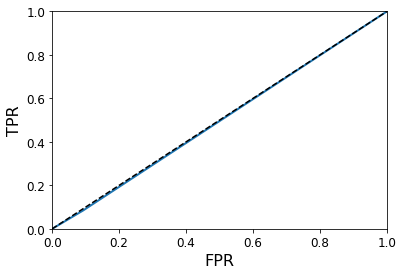

In [77]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

# 다중분류

이진 분류가 두 개의 클래스를 구별하는 반면 다중 분류기는 둘 이상의 클래스를 구별할 수 있습니다. 일부 알고리즘은 여러개의 클래스를 직접 처리 할 수 있는 반면 다른 알고리즘은 이진 분류만 가능합니다. 하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많다.
- 일대다 전략(OvA)
- 일대일 전략(OvO)

기본적으로 사이킷런에서는 다중분류작업에 이진 분류 알고리즘을 선택하면 자동으로 감지해 OvA를 적용한다. SGDClassifier를 적용하면 

In [53]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [54]:
#decision_function을 사용하여 확인했을 때 가장 큰 점수를 선택하게 된다.
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [55]:
np.argmax(some_digit_scores)

5

In [56]:
#타겟 클래스의 리스트를 값으로 정렬하여 저장 (classes_)
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [57]:
#강제적으로 OvO나 OvA를 사용하도록 하려면 OneVsOneClassifier, OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [59]:
len(ovo_clf.estimators_) #9*10/2

45

In [60]:
#RandomforestClassifier도 마찬가지다.
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [61]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [62]:
#분류기 평가에 일반적으로 교차검증을 사용하는 것을 여기서 확인 가능하다.
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

In [63]:
#다음은 좋은 결과를 내지만 단순한 스케일 조정을 통해서 정확도를 높일 수 있다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

# 에러분석

모델의 성능을 향상시키기 위해서 에러의 종류를 분석한다.

In [64]:
#오차행렬의 모습을 분석
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]],
      dtype=int64)

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


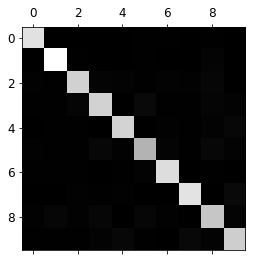

In [65]:
#오차 행렬을 맷플롯립의 matshow()함수 사용하여 이미지화
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

다음 그림에서 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선이 있으므로 매우 좋아 보인다. 단, 숫자 5는 다른 숫자보다 조금 더 어두워 보입니다. 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻입니다. 

1. 그래프의 애러부분에 초점을 맞추어본다. 오차행렬의 각 값을 대응되는 클래스이미지 개수로 나누어 이미지 비율 비교

In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


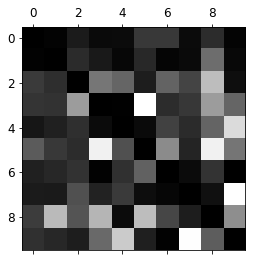

In [69]:
#주 대각선만 0으로 채워서 그래프를 그린다.
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

분류기가 만든 에러를 확실히 확인 할 수 있다. 8과9가 상당이 밝으므로 많은 이미지가 8과 9로 잘못 분류된다는 것을 확인할 수 있다. 반대로 1의 열은 매우 어두우므로 정확히 분류된다는 것이 확인된다. 

오차 행렬을 분석하면 분류기의 성능 향상 방안에 대해서 통찰을 얻을 수 있다. 

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


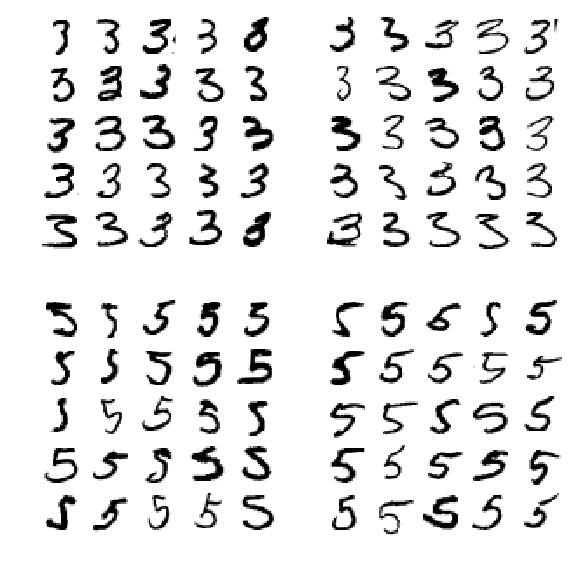

In [70]:
#3과 5 샘플
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# 다중 레이블 분류

이전까지는 각 샘플이 하나의 클래스만 할당되었다. 하지만 분류기가 샘플마다 여러개의 클래스를 출력할 때도 있다. 얼굴 인식 분류기를 생각해보자. 같은 사진에 여러 사람이 등장하면 각 사람마다 레이블을 하나씩 할당해야 한다. 앨리스 밥 찰리 세 얼굴을 인식하도록 훈련되있다고 가정해보자. 한 사진에 앨리스와 찰리가 있으면 분류기는 [1,0,1]을 출력해야 한다. 여러개의 이진 레이블을 출력하는 분류 시스템을 다중 레이블 분류시스템이라고 한다.

In [71]:
from sklearn.neighbors import KNeighborsClassifier
#KNeighborsClassifier 는 다중분류를 지원한다.
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] #1-D =>2-D

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [72]:
knn_clf.predict([some_digit])

array([[False,  True]])

# 다중 출력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한것입니다. 

이미지에서 노이즈를 제가하는 시스템을 만들어 본다고 하면 노이즈가 많은 숫자 이미지를 입력받고 깨끗한 숫자 이미지를 출력합니다. 분류기의 출력이 다중 레이블(픽셀당 한 레이블)각 레이블은 여러 개의 값을 가진다. 그래서 이 예는 다중출력 분류 시스템이다.

In [73]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


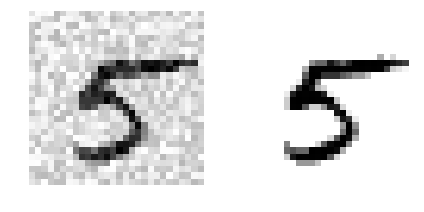

In [74]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


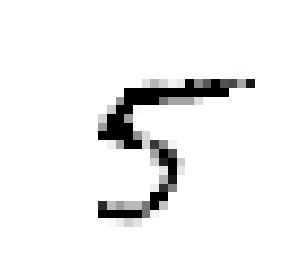

In [75]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

## KNN 분류기

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

In [ ]:
y_knn_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)